# PDF fit

Here, `k_q` is a free parameter. This is the latest verison used in the paper.

In [2]:
using BAT, DensityInterface
using PartonDensity
using QCDNUM
using Plots, Random, Distributions, ValueShapes, ParallelProcessingTools
using StatsBase, LinearAlgebra
using DelimitedFiles

gr(fmt=:png);

In [3]:
#counts_obs_ep = readdlm("data/eP.dat") 
#counts_obs_em = readdlm("data/eM.dat") 
counts_obs_ep = get_data_events(0)
counts_obs_em = get_data_events(1)

nbins = size(counts_obs_ep)[1]

153

In [4]:
#ENV["JULIA_DEBUG"] = "BAT"

┌ Info: Valence λ:
│   pdf_params.λ_u = 1.4539789916894108
│   pdf_params.λ_d = 1.5890874056682478
└ @ Main /Users/Capel/projects/high-x-parton-pdf-inference/arXiv_2209_06571/PDF-fit-dirichlet-Kq-newfit.ipynb:10
┌ Info: Momenta:
│   (pdf_params.θ[1], pdf_params.θ[2], pdf_params.θ[3], pdf_params.θ[4]) = (0.4505682443533376, 0.24116957445445916, 0.1398097012024484, 0.09418602479068261)
└ @ Main /Users/Capel/projects/high-x-parton-pdf-inference/arXiv_2209_06571/PDF-fit-dirichlet-Kq-newfit.ipynb:11


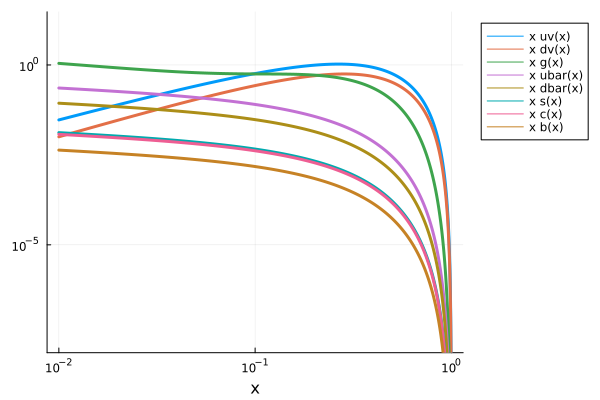

In [5]:
# Specify the input PDFs

pdf_params = DirichletPDFParams(K_u=4.0, K_d=4.0, λ_g1=1.5, λ_g2=-0.4, K_g=6.0,
    λ_q=-0.25, K_q=5, weights=[30.0, 15.0, 12.0, 6.0, 3.6, 0.85, 0.85, 0.85, 0.85]);

#pdf_params = DirichletPDFParams(K_u=4.0, K_d=4.0, λ_g1=1.2, λ_g2=-0.4, K_g=4.0,
#                                λ_q=-0.4, weights=[6., 3., 9., 4.0, 2.,1., 0.2, 0.2, 0.1]);

# replace weights with θ to specify the momentum fractions directly
@info "Valence λ:" pdf_params.λ_u pdf_params.λ_d
@info "Momenta:" pdf_params.θ[1],pdf_params.θ[2],pdf_params.θ[3],pdf_params.θ[4]
plot_input_pdfs(pdf_params)

In [6]:
# Specify QCDNUM inputs
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);

# now SPLINT and quark coefficients
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();

# initialise QCDNUM
#forward_model_init(qcdnum_grid, qcdnum_params, splint_params) # without systematic errors
forward_model_init_sysErr(qcdnum_grid, qcdnum_params, splint_params) # with systematic errors

  +---------------------------------------------------------------------+   
  |                                                                     |   
  |    If you use QCDNUM, please refer to:                              |   
  |                                                                     |   
  |    M. Botje, Comput. Phys. Commun. 182(2011)490, arXiV:1005.1481    |   
  |                                                                     |   
  +---------------------------------------------------------------------+   
  
  

 FILLWT: start unpolarised weight calculations
 Subgrids    3 Subgrid points   15   50   75
 Pij LO
 Pij NLO
 Pij NNLO
 Aij LO
 Aij NLO
 Aij NNLO
 FILLWT: weight calculations completed


 ZMFILLW: start weight calculations   4  38   0   0
 ZMFILLW: calculations completed

  +---------------------------------------+
  | You are using SPLINT version 20220308 |
  +---------------------------------------+


0.00019953
0.00016954
0.00019447
1.752500000000

In [9]:
# Plot the data
scatter(1:nbins, counts_obs_ep, label="Detected counts (eP)", color="blue")
scatter!(1:nbins, counts_obs_em, label="Detected counts (eM)", color="red")
plot!(xlabel="Bin number")
savefig("figures/data-sysrun-ZEUS-2.png");

In [10]:
# store in array
obs_data = Dict{String, Any}()
obs_data["nbins"] = nbins;
obs_data["counts_obs_ep"] = counts_obs_ep;
obs_data["counts_obs_em"] = counts_obs_em;

In [11]:
# Specify prior
# loosen the prior on K_g and negative lambdas
prior = NamedTupleDist(
    θ = Dirichlet([20.,10.,22.,22.,2,2,1,1,0.5]),
    K_u = Truncated(Normal(3.5, 0.5), 2., 5.),
    K_d = Truncated(Normal(3.5, 0.5), 2., 5.),
    λ_g1 = Uniform(0., 2.),
    λ_g2 = Uniform(-1.0, -0.1),
    K_g =  Truncated(Normal(4., 1.5), 2., 7.),
    λ_q = Uniform(-1.0, -0.1),
    K_q = Truncated(Normal(5., 1.5), 3., 10.),
    Beta1 =  Truncated(Normal(0, 1), -5, 5),
    Beta2 =  Truncated(Normal(0, 1), -5, 5),
    beta0_1=  Truncated(Normal(0, 1), -5, 5), 
    beta0_2=   Truncated(Normal(0, 1), -5, 5),    
    beta0_3= Truncated(Normal(0, 1), -5, 5), 
    beta0_4=  Truncated(Normal(0, 1), -5, 5), 
    beta0_5=  Truncated(Normal(0, 1), -5, 5), 
    beta0_6=  Truncated(Normal(0, 1), -5, 5), 
    beta0_7=  Truncated(Normal(0, 1), -5, 5), 
    beta0_8=   Truncated(Normal(0, 1), -5, 5)
);

In [13]:
# Likelihood 

likelihood = let d = obs_data

    counts_obs_ep = d["counts_obs_ep"]
    counts_obs_em = d["counts_obs_em"]
    nbins = d["nbins"]

    logfuncdensity(function (params)

       pdf_params = DirichletPDFParams(K_u=params.K_u, K_d=params.K_d, λ_g1=params.λ_g1, λ_g2=params.λ_g2,
            K_g=params.K_g, λ_q=params.λ_q, K_q=params.K_q, θ=params.θ)


            #Ensure u-valence weight > d-valence weight
            if params.θ[2] > params.θ[1]

                return -Inf

            end
          
            ParErrs = [params.beta0_1,params.beta0_2,params.beta0_3,params.beta0_4,
                params.beta0_5,params.beta0_6,params.beta0_7,params.beta0_8]
            
            counts_pred_ep, counts_pred_em = @critical  forward_model_sysErr(pdf_params, 
                qcdnum_params, splint_params, quark_coeffs, ParErrs); # with systematic errors
            # counts_pred_ep, counts_pred_em = @critical forward_model(pdf_params,
            #     qcdnum_params, splint_params, quark_coeffs); # without systematic errors

            ll_value = 0.0
            for i in 1:nbins

                if counts_pred_ep[i] < 0
                   @debug "counts_pred_ep[i] < 0, setting to 0" i counts_pred_ep[i]
                   counts_pred_ep[i] = 0
                end

                if counts_pred_em[i] < 0
                   @debug "counts_pred_em[i] < 0, setting to 0" i counts_pred_em[i]
                   counts_pred_em[i] = 0
                end
                
                counts_pred_ep[i] =counts_pred_ep[i]*(1+0.018*params.Beta1)
                counts_pred_em[i] =counts_pred_em[i]*(1+0.018*params.Beta2)

                ll_value += logpdf(Poisson(counts_pred_ep[i]), counts_obs_ep[i])
                ll_value += logpdf(Poisson(counts_pred_em[i]), counts_obs_em[i])
            end

            return ll_value
    end)
end;

In [14]:
# Fit with BAT

posterior = PosteriorDensity(likelihood, prior);
mcalg = MetropolisHastings(proposal=BAT.MvTDistProposal(10.0))
convergence = BrooksGelmanConvergence(threshold=1.3);
burnin = MCMCMultiCycleBurnin(max_ncycles=50);

samples = bat_sample(posterior, MCMCSampling(mcalg=mcalg, nsteps=1*10^5, nchains=2)).result;

In [19]:
# Save

import HDF5
bat_write("data/Data-Dirichlet-ZEUS-Test.h5", samples)

In [21]:
# Summary

open("data/report-ZEUS-Test.txt", "w") do io
   show(io, MIME"text/plain"(), bat_report(samples))
end